In [1]:
import ReservoirComputer_3 as ReCom
import numpy as np
import scipy.sparse as sp
import ReservoirPlot as resplt
import ReservoirAnalysis as resan
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets

## Define functions and generate training and valuation data. Check if parameters work:

In [2]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])

def RMSE(pred, target, T):
    square_dist = np.asarray([np.linalg.norm(pred[t] - target[t])**2 for t in range(T)])
    return np.sqrt(square_dist.sum()/T)


def plot_traj(traj, t_start=0, t_end=40000, xlim=300, ylim=300, zlim=300):
    fig = plt.figure(figsize=(15,9))
    ax = fig.gca(projection="3d")
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "b-",
                markersize=2.0, alpha=0.5)
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                markersize=2.0, alpha=1.0)
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)
  

def evolve(RC, ics, t_points):
    ics = ics.copy()
    ics.append(RC.r_T)
    n = int(round(T/dt))
    traj = np.zeros((len(ics), len(t_points), RC.d))
    
    for i in range(len(ics)):
        r0 = ics[i]
        PR_traj = integrate.odeint(RC.f_PR, r0, t_points)
        prediction = np.asarray([RC.W_out.dot(RC.q(p)) for p in PR_traj])
        traj[i,:,:] = prediction
    
    return traj 

def plot_traj(traj, t_start=0, t_end=15000, xlim=300, ylim=300, zlim=300):
    fig = plt.figure(figsize=(15,9))
    ax = fig.gca(projection="3d")
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], "b-",
                markersize=2.0, alpha=0.5)
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                markersize=2.0, alpha=1.0)
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)


In [3]:
T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

In [4]:
train_data.shape

(10000, 3)

In [5]:
RC = ReCom.ESN(N=100, p=0.01, d=3, rho=0.9, sigma=0.014, gamma=10.0, beta=1e-6)

In [6]:
%%time 
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

Wall time: 1.15 s


## Write & test code for anti-hebbian learning rule for implementing synaptic plasticity.

In [28]:
eta = 1e-7
E = 1
size_E = 9999 #No higher than 9999
x = training_traj
X = np.zeros((RC.N,RC.N))
M = RC.M.copy()

for e in range(E):
    for t in range(1, size_E):
        for i in range(RC.N):
            X[i,:] = x[t+1,i] * x[t,:]
        M = -(M + eta*X)
    
M = sp.csr_matrix(M)

In [29]:
RC_heb = ReCom.ESN(N=100, p=0.01, d=3, rho=0.9, sigma=0.014, gamma=10.0, beta=1e-6)
RC_heb.M = M
RC_heb.W_in = RC.W_in.copy()
RC_heb.W_out = RC.W_out.copy()
RC_heb.r_T = RC.r_T.copy()

In [30]:
prediction_heb = RC_heb.predict(t_points_prediction)

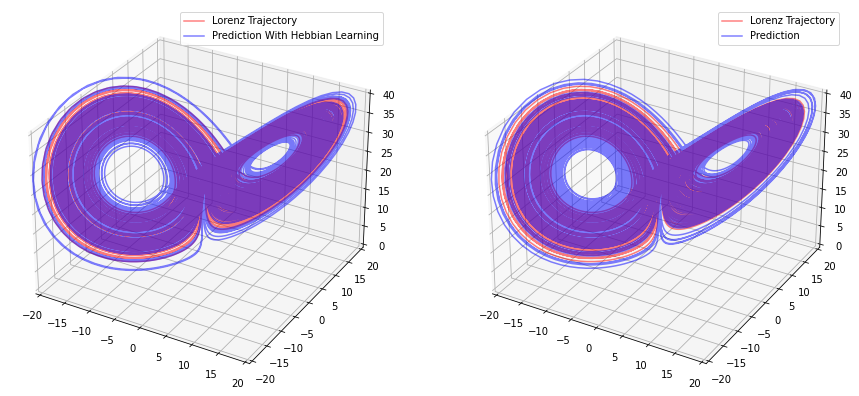

In [31]:
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax1.plot(prediction_heb[:-1,0], prediction_heb[:-1,1], prediction_heb[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction With Hebbian Learning')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax2.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

xlim, ylim, zlim = 20, 20, 40
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_zlim(0, zlim)
ax1.legend()

ax2.set_xlim(-xlim, xlim)
ax2.set_ylim(-ylim, ylim)
ax2.set_zlim(0, zlim)
ax2.legend()

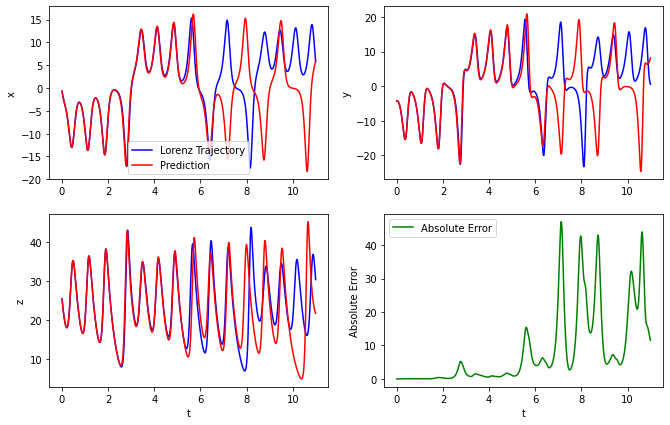

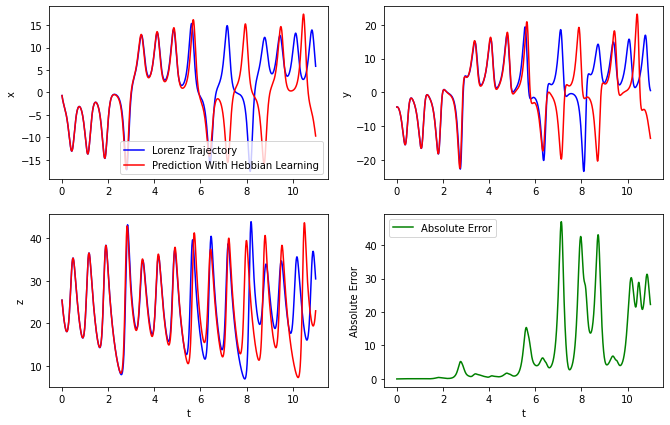

In [11]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)
resplt.plot_short_pred(val_data, prediction_heb, 'Lorenz Trajectory', 'Prediction With Hebbian Learning', t_points_prediction, 0, 1100)

In [12]:
RC = ReCom.ESN(N=100, p=0.01, d=3, rho=0.9, sigma=0.014, gamma=10.0, beta=1e-6)

In [13]:
%%time 
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

Wall time: 1.16 s


In [14]:
%%time
RC.hebb_learn(eta=1e-7, E=1)
prediction = RC.predict(t_points_prediction)

Wall time: 2.96 s


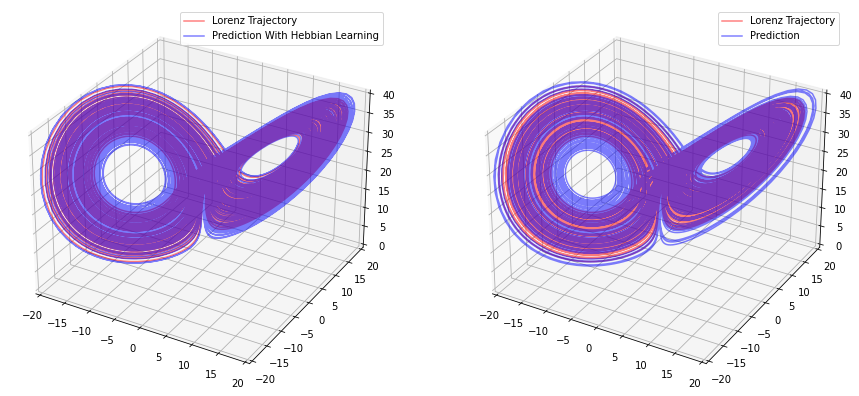

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax1.plot(prediction_heb[:-1,0], prediction_heb[:-1,1], prediction_heb[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction With Hebbian Learning')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax2.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

xlim, ylim, zlim = 20, 20, 40
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_zlim(0, zlim)
ax1.legend()

ax2.set_xlim(-xlim, xlim)
ax2.set_ylim(-ylim, ylim)
ax2.set_zlim(0, zlim)
ax2.legend()

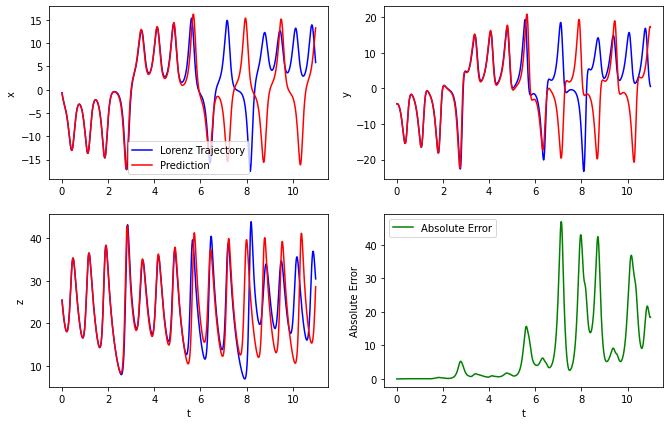

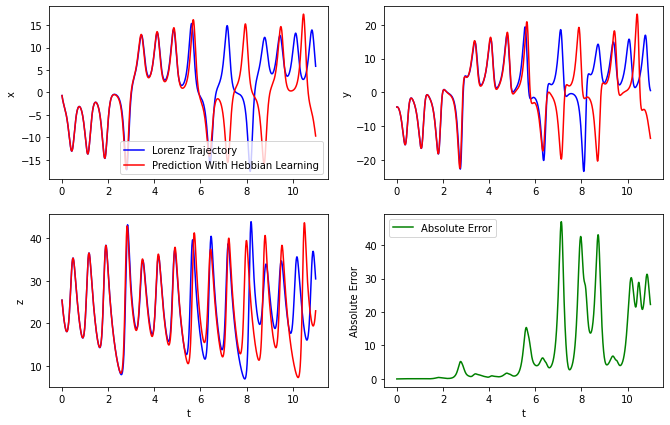

In [16]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)
resplt.plot_short_pred(val_data, prediction_heb, 'Lorenz Trajectory', 'Prediction With Hebbian Learning', t_points_prediction, 0, 1100)

## Write and test function to carry out AHL:

In [7]:
def anti_heb(RC, train_data, t_points_training, t_listen, training_traj, eta, E, size_E=9999):
    x = training_traj
    X = np.zeros((RC.N,RC.N))
    M = RC.M.copy()

    for e in range(E):
        for t in range(1, size_E):
            for i in range(RC.N):
                X[i,:] = x[t+1,i] * x[t,:]
            M = M - eta*X
    
    M = sp.csr_matrix(M)
    RC_heb = ReCom.ESN(N=RC.N, p=RC.p, d=RC.d, rho=RC.rho, sigma=RC.sigma, gamma=RC.gamma, beta=RC.beta)
    RC_heb.M = M
    RC_heb.W_in = RC.W_in.copy()
    training_traj_heb = RC_heb.train(train_data, t_points_training, t_listen)
    return RC_heb


def anti_heb2(RC, train_data, t_points_training, t_listen, training_traj, eta, E, size_E=9999):
    x = training_traj
    X = np.zeros((RC.N,RC.N))
    M = RC.M.copy()

    for e in range(E):
        for t in range(1, size_E):
            for i in range(RC.N):
                X[i,:] = x[t+1,i] * x[t,:]
            M = -(M + eta*X)
        M = sp.csr_matrix(M)    
        RC_heb = ReCom.ESN(N=RC.N, p=RC.p, d=RC.d, rho=RC.rho, sigma=RC.sigma, gamma=RC.gamma, beta=RC.beta)
        RC_heb.M = M
        RC_heb.W_in = RC.W_in.copy()
        x = RC_heb.train(train_data, t_points_training, t_listen)
        
    
#     M = sp.csr_matrix(M)
#     RC_heb = ReCom.ESN(N=RC.N, p=RC.p, d=RC.d, rho=RC.rho, sigma=RC.sigma, gamma=RC.gamma, beta=RC.beta)
#     RC_heb.M = M
#     RC_heb.W_in = RC.W_in.copy()
#     training_traj_heb = RC_heb.train(train_data, t_points_training, t_listen)
    return RC_heb

In [8]:
RC_heb = anti_heb(RC, train_data, t_points_training, 5000, training_traj, eta=1, E=1)
RC_heb2 = anti_heb2(RC, train_data, t_points_training, 5000, training_traj, eta=1, E=1)

In [9]:
prediction_heb = RC_heb.predict(t_points_prediction)
prediction_heb2 = RC_heb2.predict(t_points_prediction)

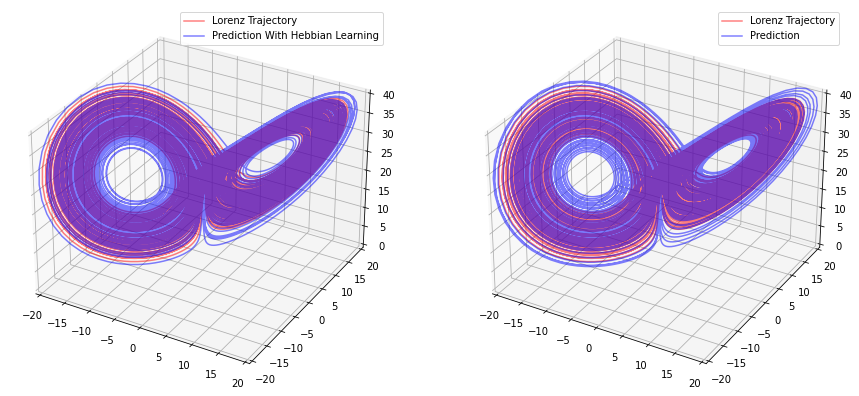

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax1.plot(prediction_heb2[:-1,0], prediction_heb2[:-1,1], prediction_heb2[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction With Hebbian Learning')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax2.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

xlim, ylim, zlim = 20, 20, 40
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_zlim(0, zlim)
ax1.legend()

ax2.set_xlim(-xlim, xlim)
ax2.set_ylim(-ylim, ylim)
ax2.set_zlim(0, zlim)
ax2.legend()

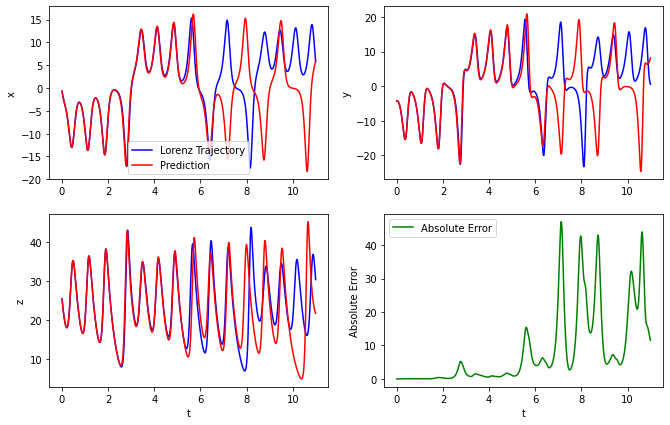

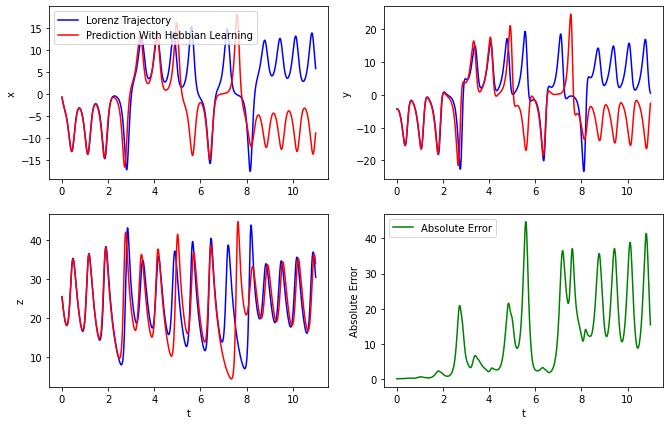

In [12]:
resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)
resplt.plot_short_pred(val_data, prediction_heb2, 'Lorenz Trajectory', 'Prediction With Hebbian Learning', t_points_prediction, 0, 1100)

## Run learning rule for different parameter values:

In [34]:
%%time
eta_list = [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
predictions = np.zeros((11, 10, 15000, 3))
predictions2 = np.zeros((11, 10, 15000, 3))
for i in range(10):
    for j in range(1, 10):
        RC_heb = anti_heb(RC, train_data, t_points_training, 5000, training_traj, eta=eta_list[i], E=j)
        prediction_heb = RC_heb.predict(t_points_prediction)
        predictions[i, j, :,:] = prediction_heb.copy()
        
        RC_heb2 = anti_heb2(RC, train_data, t_points_training, 5000, training_traj, eta=eta_list[i], E=j)
        prediction_heb2 = RC_heb2.predict(t_points_prediction)
        predictions2[i, j, :,:] = prediction_heb2.copy()

    

Wall time: 33min 33s


In [35]:
%matplotlib inline
@widgets.interact(i=(0, 10, 1), j=(0, 10, 1), xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=0, xlim=50, ylim=50, zlim=50):
    prediction_heb = predictions[i, j]
    prediction_heb2 = predictions2[i, j]
    
    fig = plt.figure(figsize=(15,9))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
    ax1.plot(prediction_heb[:-1,0], prediction_heb[:-1,1], prediction_heb[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction With Hebbian Learning')

    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
    ax2.plot(prediction_heb2[:-1,0], prediction_heb2[:-1,1], prediction_heb2[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction With Hebbian Learning 2')

    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
    ax3.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

    xlim, ylim, zlim = 20, 20, 40
    ax1.set_xlim(-xlim, xlim)
    ax1.set_ylim(-ylim, ylim)
    ax1.set_zlim(0, zlim)
    ax1.legend()

    ax2.set_xlim(-xlim, xlim)
    ax2.set_ylim(-ylim, ylim)
    ax2.set_zlim(0, zlim)
    ax2.legend()
    
    ax3.set_xlim(-xlim, xlim)
    ax3.set_ylim(-ylim, ylim)
    ax3.set_zlim(0, zlim)
    ax3.legend()
    
    resplt.plot_short_pred(val_data, prediction_heb, 'Lorenz Trajectory', 'Prediction With Hebbian Learning', t_points_prediction, 0, 1100)
    resplt.plot_short_pred(val_data, prediction_heb2, 'Lorenz Trajectory', 'Prediction With Hebbian Learning 2', t_points_prediction, 0, 1100)
    resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)
    print("Eta = " + str(eta_list[i]))
    print("Epochs = " + str(j))

interactive(children=(IntSlider(value=0, description='i', max=10), IntSlider(value=0, description='j', max=10)…

## Same again, but checking for other attractors.

In [36]:
%%time
eta_list = [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
predictions = np.zeros((11, 21, 15001, 3))
T = 150
dt = 0.01
n = int(round(T/dt))
t_points = np.linspace(0, T, n+1)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))

for i in range(10):
    #for j in range(10):
    RC_heb = anti_heb(RC, train_data, t_points_training, 5000, training_traj, eta=eta_list[i], E=1)
    #prediction_heb = RC_heb.predict(t_points_prediction)
    pert_traj = evolve(RC_heb, ics, t_points)
    #predictions[i, j, :,:] = prediction_heb
    predictions[i,:,:,:] = pert_traj


Wall time: 2min 23s


In [37]:
%matplotlib inline
@widgets.interact(i=(0, 10, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, t_start=0, t_end=15000, xlim=50, ylim=50, zlim=50):
    prediction_heb = predictions[i, j]
    
    fig = plt.figure(figsize=(15,9))
    
#     ax1 = fig.add_subplot(121, projection='3d')
#     ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
#     ax1.plot(prediction_heb[:-1,0], prediction_heb[:-1,1], prediction_heb[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction With Hebbian Learning')
    plot_traj(predictions[i], t_start, t_end, xlim, ylim, zlim)
    
#     ax2 = fig.add_subplot(122, projection='3d')
#     ax2.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
#     ax2.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

    xlim, ylim, zlim = 20, 20, 40
    ax1.set_xlim(-xlim, xlim)
    ax1.set_ylim(-ylim, ylim)
    ax1.set_zlim(0, zlim)
    ax1.legend()

    ax2.set_xlim(-xlim, xlim)
    ax2.set_ylim(-ylim, ylim)
    ax2.set_zlim(0, zlim)
    ax2.legend()
    
    resplt.plot_short_pred(val_data, prediction, 'Lorenz Trajectory', 'Prediction', t_points_prediction, 0, 1100)
    resplt.plot_short_pred(val_data, prediction_heb, 'Lorenz Trajectory', 'Prediction With Hebbian Learning', t_points_prediction, 0, 1100)
    
    print("Eta = " + str(eta_list[i]))

interactive(children=(IntSlider(value=0, description='i', max=10), IntSlider(value=0, description='t_start', m…

NameError: name 'RC' is not defined